# Data treatment

Import Dataset

In [3]:
import numpy as np

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data = []
labels = []
for i in range(5):
    batch = unpickle(f"../data/raw/data_batch_{i+1}")
    data.append(batch[b"data"])
    labels.extend(batch[b"labels"])

Xtemp, y = np.concatenate(data), np.array(labels)

Convert Images to PIL ones

In [4]:
from PIL import Image

def convert_to_image(data, index):
    single_image_data = data[index]
    single_image_data = single_image_data.reshape((3, 32, 32))
    single_image_data = single_image_data.transpose((1, 2, 0))

    img = Image.fromarray(single_image_data, 'RGB')
    return img

X = []
for i in range(len(Xtemp)):
    X.append(convert_to_image(Xtemp, i))

Check data

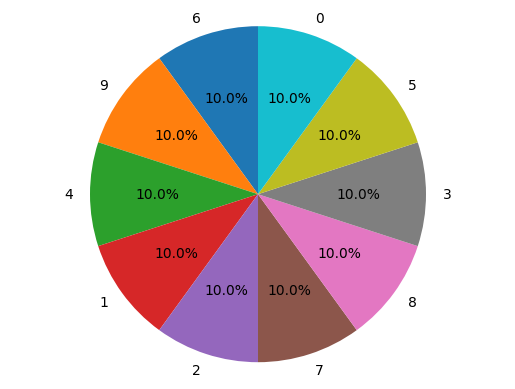

In [13]:
import matplotlib.pyplot as plt
from collections import Counter

label_freq = Counter(y)
label_perc = {i: count/len(y)*100 for i, count in label_freq.items()}
labels = label_perc.keys()
sizes = label_perc.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

ax1.axis('equal')

plt.show()

Get mosaic of each classes

In [15]:
#import math
#import numpy as np
#
#def display_images_by_label(X, y, target_label, show=False):
#    indices = [i for i, label in enumerate(y) if label == target_label]
#    filtered_images = X[indices]
#
#    images_per_row = math.ceil(math.sqrt(len(filtered_images)))
#    images_per_column = images_per_row
#
#    mosaic_width = 32 * images_per_row
#    mosaic_height = 32 * images_per_column
#    mosaic = Image.new('RGBA', (mosaic_width, mosaic_height))
#
#    for index in range(len(filtered_images)):
#        row = index // images_per_row
#        column = index % images_per_row
#        mosaic.paste(filtered_images[i], (column * 32, row * 32))
#
#    mosaic.save(f"./results/mosaic_{target_label}.png")
#    if show:
#        mosaic.show()
#
#for label in np.unique(y):
#    display_images_by_label(X, y, target_label=label)

# Features extraction

HOG

In [16]:
from skimage.feature import hog
from skimage import color
import numpy as np
from tqdm import tqdm

def extract_hog_features(images):
    hog_features_list = []

    for img in tqdm(images):
        img = np.array(img)
        img_gray = color.rgb2gray(img)

        hog_features = hog(img_gray, orientations=16, pixels_per_cell=(8, 8),
                           cells_per_block=(4, 4), visualize=False, transform_sqrt=True)
        hog_features_list.append(hog_features)

    return hog_features_list

hog_features = extract_hog_features(X)
hog_features[0].shape

100%|██████████| 50000/50000 [00:25<00:00, 1967.32it/s]


(256,)

In [17]:
import seaborn as sns
import pandas as pd

corr = pd.DataFrame(hog_features).corr()

f, ax = plt.subplots(figsize=(99, 81), dpi=160)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, center=0,
            square=True, cbar_kws={"shrink": .5})

<Axes: >

LBP

In [18]:
from skimage import feature
import numpy as np

def extract_lbp_features(X, P=32, R=4):
    lbp_features = []
    for img in X:
        img_gray = img.convert('L')
        img_arr = np.array(img_gray)
        lbp = feature.local_binary_pattern(img_arr, P, R)
        hist, _ = np.histogram(lbp, density=True, bins=P, range=(0, P - 1))
        hist[np.isnan(hist)] = 0
        lbp_features.append(hist)
    return lbp_features

lbp_features = extract_lbp_features(X)
lbp_features[0]

c:\Users\RINGULARITY\.conda\envs\ml\Lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


array([0.84457478, 0.05865103, 0.02346041, 0.        , 0.04692082,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01173021, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02346041,
       0.        , 0.        , 0.        , 0.01173021, 0.        ,
       0.        , 0.01173021])

<Axes: >

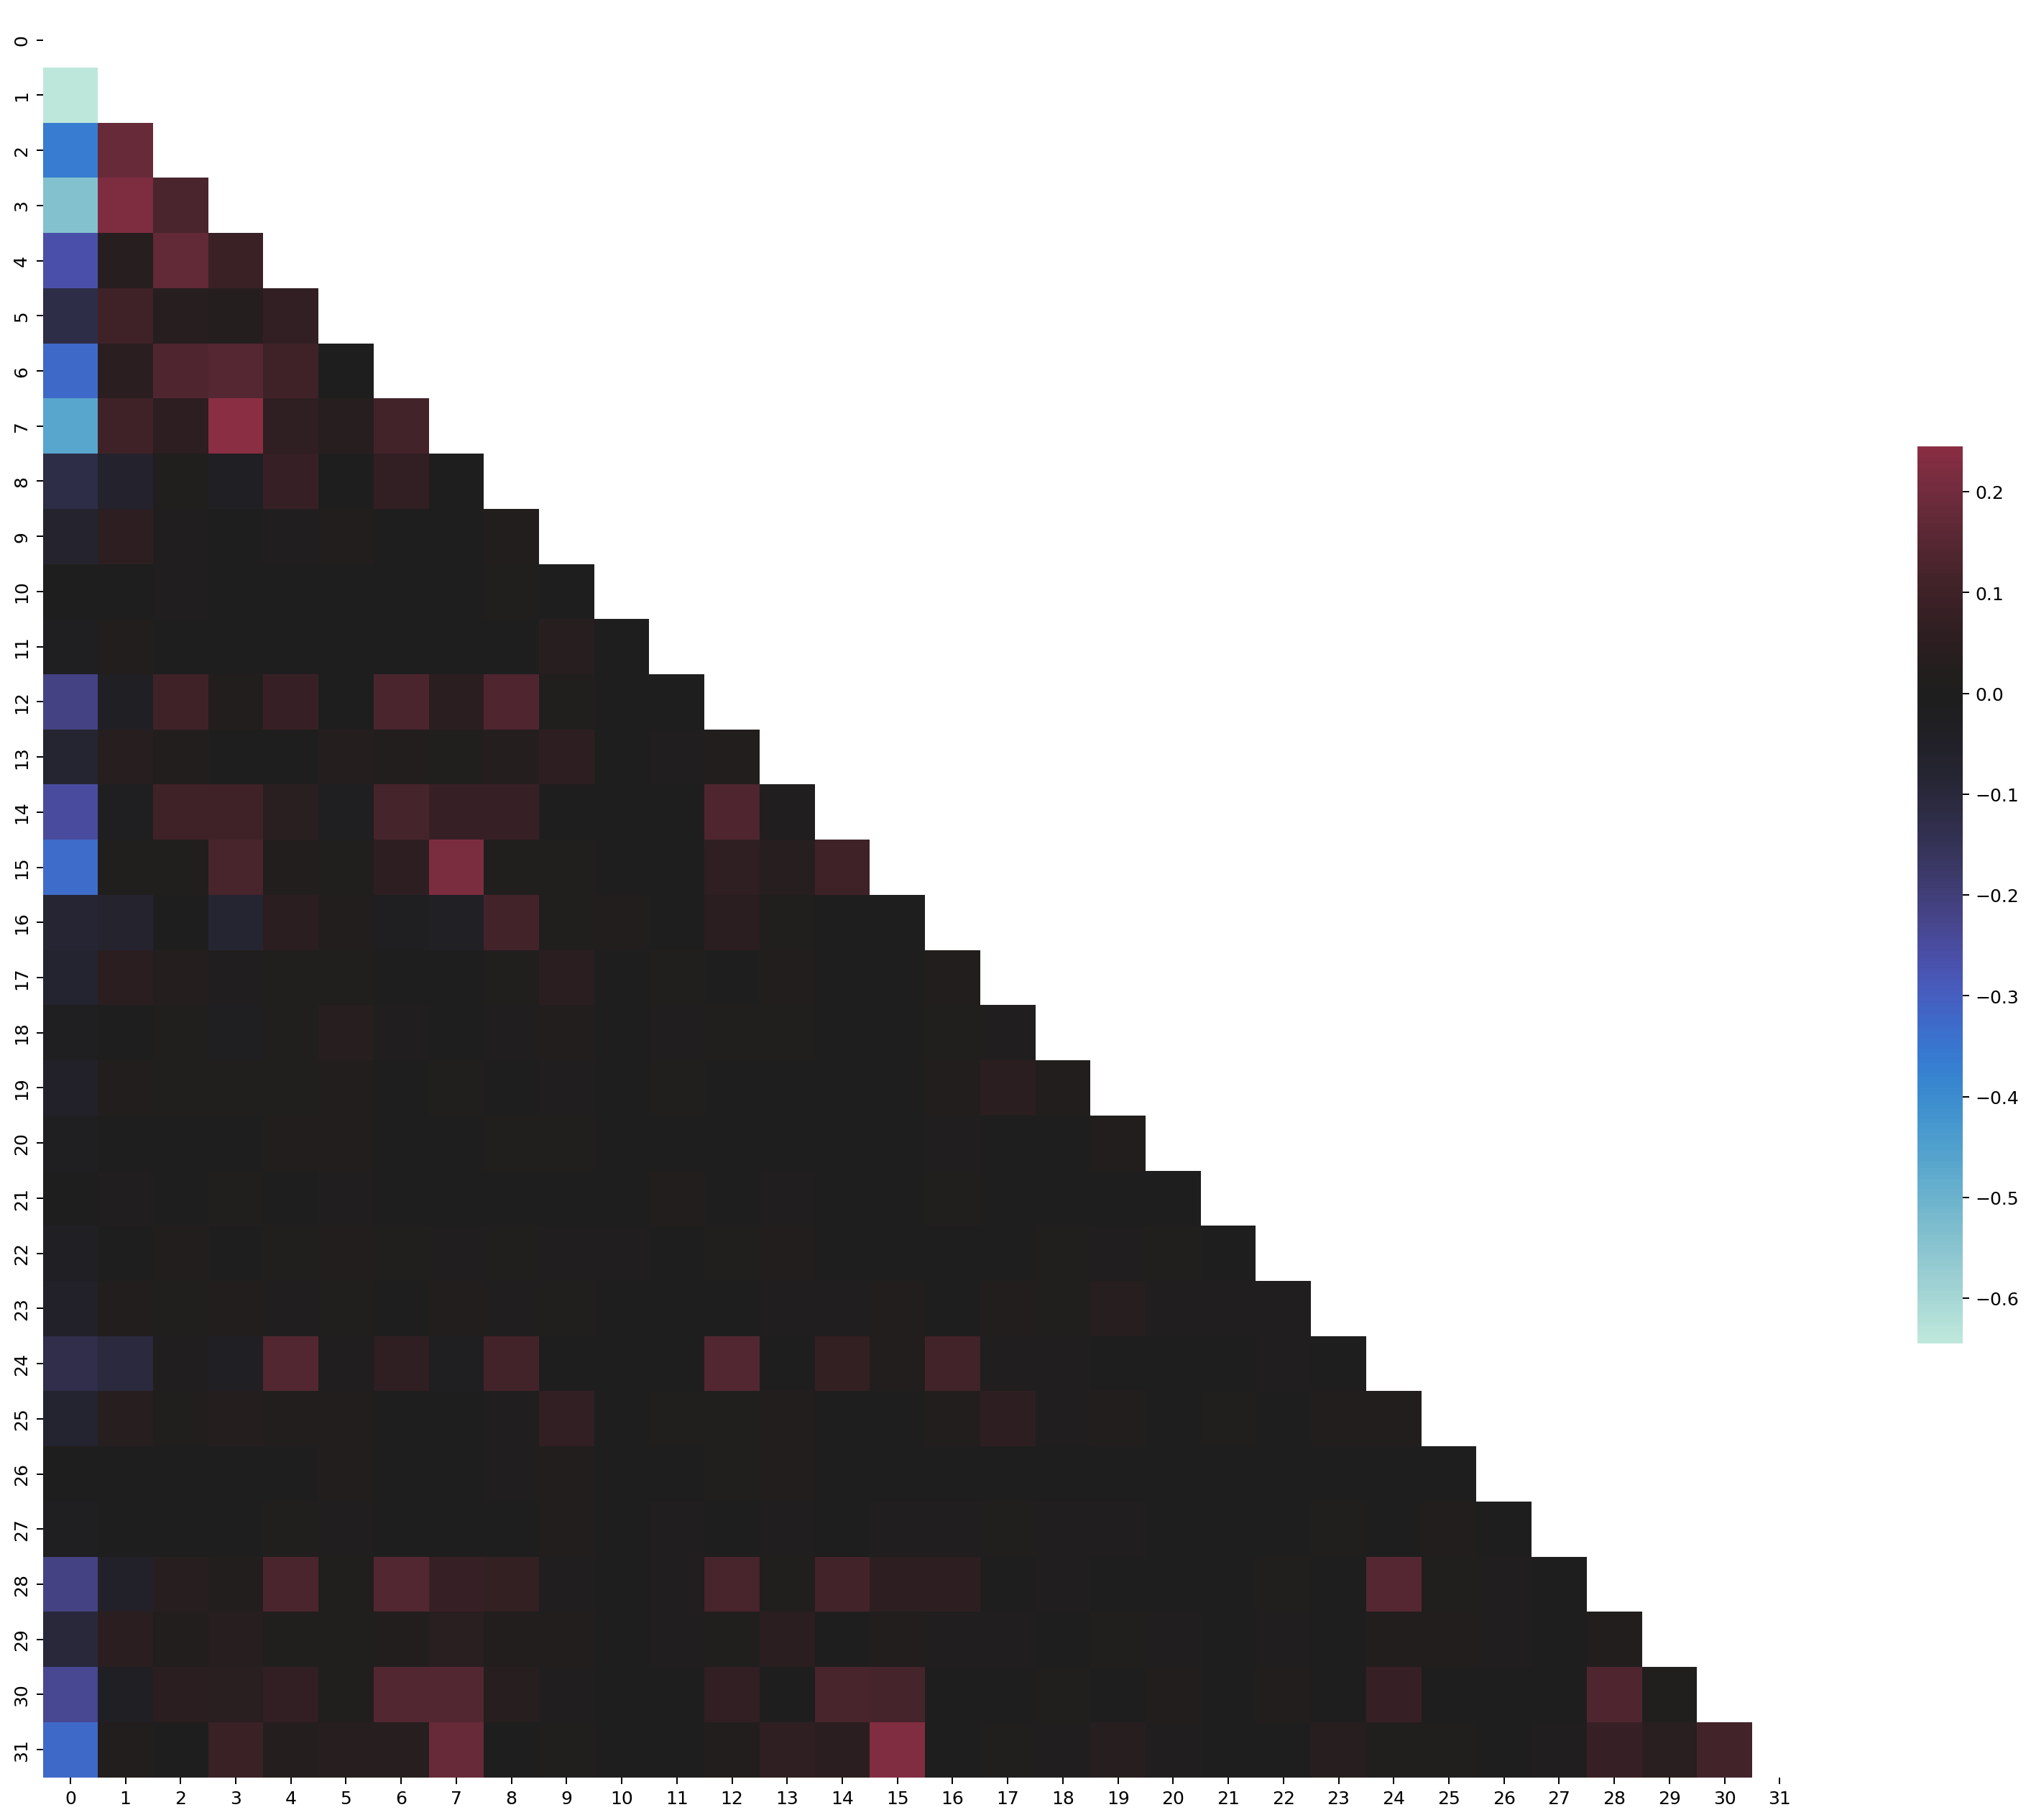

In [19]:
corr = pd.DataFrame(lbp_features).corr()

f, ax = plt.subplots(figsize=(22, 18), dpi=180)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, center=0,
            square=True, cbar_kws={"shrink": .5})

Flatten

In [20]:
def flatten_images(images):
    flattened_images = []
    for img in images:
        flattened_img = np.array(img).flatten()
        flattened_images.append(flattened_img)
    return flattened_images

X_flattened = flatten_images(X)

# Classification

SVM

In [8]:
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(y, classes=np.unique(y))
all_features = np.hstack((hog_features, lbp_features, X_flattened))
all_features.shape

(10000, 6240)

c:\Users\RINGULARITY\.conda\envs\ml\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\RINGULARITY\.conda\envs\ml\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\RINGULARITY\.conda\envs\ml\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\RINGULARITY\.conda\envs\ml\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\RINGULARITY\.conda\envs\ml\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\RINGULARITY\.conda\envs\ml\Lib\site-packages\sklearn\svm\_base.py:1244: Conv

Accuracy:  0.24333333333333335


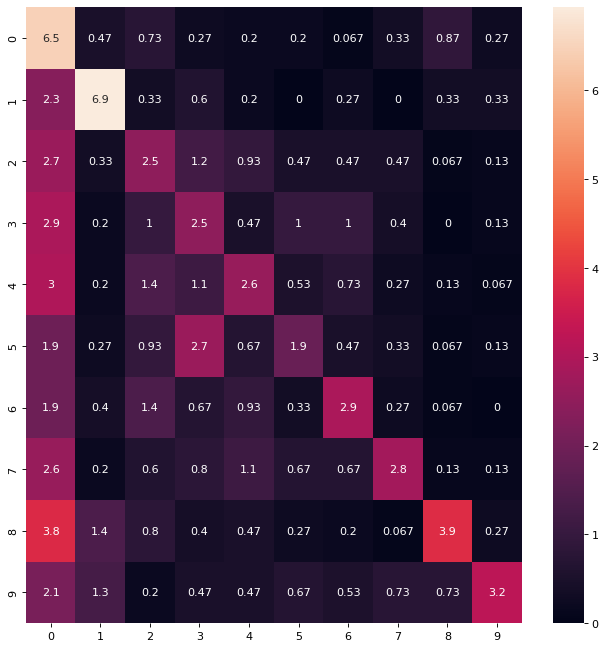

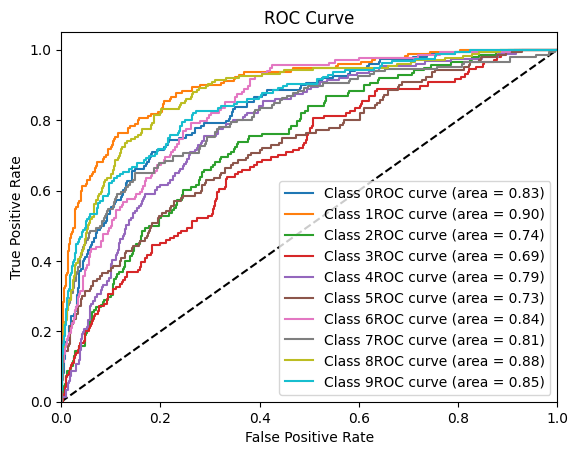

In [9]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from seaborn import heatmap

X_train, X_test, y_train, y_test = train_test_split(all_features, y_bin, test_size=0.15, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

classifier = OneVsRestClassifier(svm.LinearSVC(random_state=42))
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("Accuracy: ", accuracy)
plt.figure(figsize=(10, 10), dpi=80)
heatmap(100 * conf_mat / np.sum(np.sum(conf_mat)), annot=True)

n_classes = y_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i}' + 'ROC curve (area = %0.2f)' % roc_auc[i])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Accuracy: 0.39666666666666667


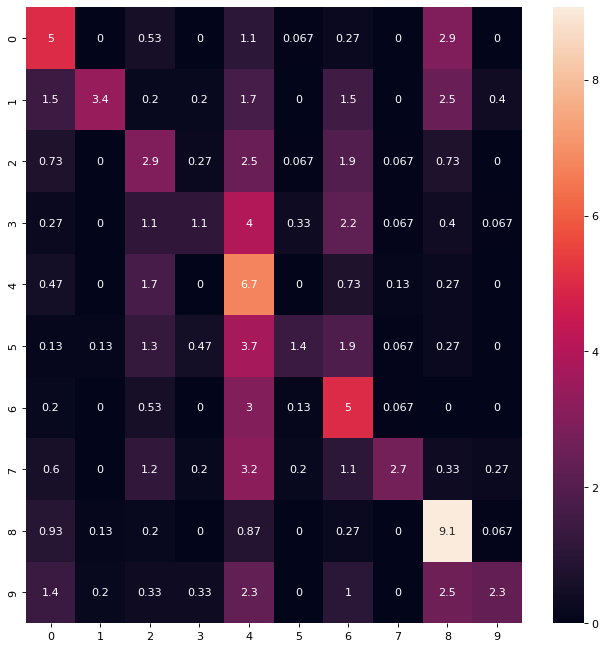

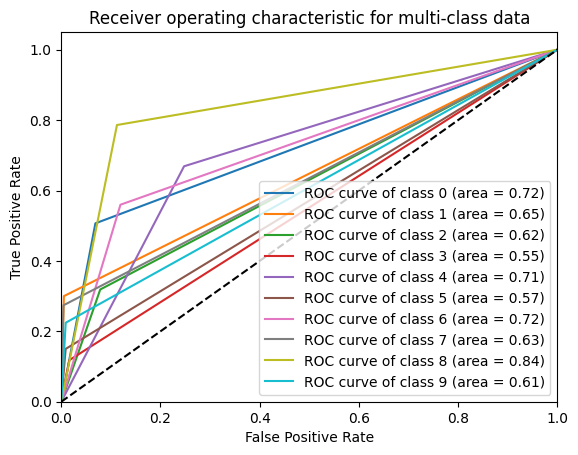

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(all_features, y, test_size=0.15, random_state=42)
classes = np.unique(y)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=len(classes))
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)

y_test_bin = label_binarize(y_test, classes=classes)
y_pred_knn_bin = label_binarize(y_pred_knn, classes=classes)

print(f"Accuracy: {accuracy_knn}")
plt.figure(figsize=(10, 10), dpi=80)
heatmap(100 * cm_knn / np.sum(np.sum(cm_knn)), annot=True)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_knn_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

XG-Boost

Accuracy: 0.5946666666666667


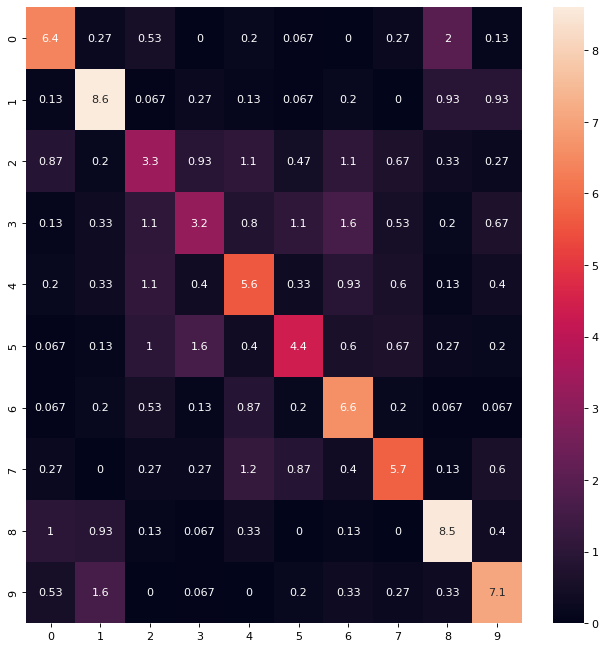

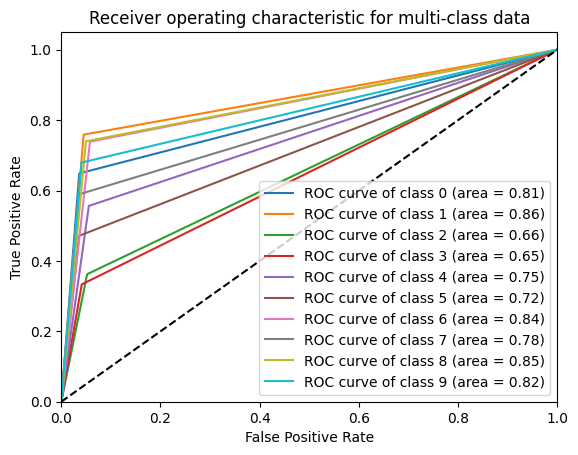

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy.optimize import differential_evolution
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(all_features, y, test_size=0.15, random_state=42)
classes = np.unique(y)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

def optimize(params):
    max_depth, n_estimators = params
    model = XGBClassifier(learning_rate=0.1, max_depth=int(max_depth), n_estimators=int(n_estimators), tree_method='gpu_hist')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return 1 - accuracy_score(y_test, y_pred)

#bounds = [(20, 100), (250, 5000)]
#result = differential_evolution(optimize, bounds)
#max_depth, n_estimators = result.x

max_depth = 25
n_estimators = 500
model = XGBClassifier(learning_rate=0.1, max_depth=int(max_depth), n_estimators=int(n_estimators), tree_method='gpu_hist')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
plt.figure(figsize=(10, 10), dpi=80)
heatmap(100 * cm / np.sum(np.sum(cm)), annot=True)

y_test_bin = label_binarize(y_test, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")